# Extended Data Fig 6

## Setup

In [1]:
# Set working directory
%cd notebooks
# Autoreload
%load_ext autoreload
%autoreload 2
# Use rpy2 to run R in python notebook for plotting
%load_ext rpy2.ipython

/home/jovyan/work/notebooks


In [2]:
# Import local code
import sys
sys.path.append('/home/jovyan/work/code')
from gradientVersion import *
from processing import *
from analysis_helpers import *
from triplets import *
from enrichments_data import *
from enrichments import *
from single_cell import *
from brainspan import *
from maps_data import *
from maps_analysis import *
from maps_null_test import *
from disorders_data import *
from disorders import *

In [5]:
%%R 
source("../code/fig_extended.R")


System has not been booted with systemd as init system (PID 1). Can't operate.
Failed to connect to bus: Host is down


In [3]:
pca_base = gradientVersion(approach='pca', kernel=None).fit('hcp_base')
dme_3d_ds5 = gradientVersion(approach='dm', kernel='normalized_angle', alpha=1).fit('hcp_3d_ds5')

New gradients version: method=pca, kernel=None, sparsity=0, data=hcp_base
New gradients version: method=dm, kernel=normalized_angle, sparsity=0, data=hcp_3d_ds5


In [4]:
weights = dme_3d_ds5.weights.iloc[:,:3]
null_weights = shuffle_gene_weights(weights, n=5000, rank=False)

---

In [6]:
gwas = get_gwas_combined()

In [7]:
deg_studies = get_deg_combined().assign(
    disorder = lambda x: x['label'].str.split('--', expand=True)[0],
    label = lambda x: x['label'].str.split('--', expand=True)[1]
)

gwas_studies = (gwas
                .rename({'label':'disorder'}, axis=1)
                .assign(label= lambda x: x['disorder'].map({
                    'SCZ':'Trubetskoy 2022\n(GWAS)',
                    'ASD':'Matoba 2020\n(GWAS)',
                    'MDD':'Howard 2019\n(GWAS)'
                }))
)

deg_studies_and_gwas = pd.concat([deg_studies, gwas_studies])

### Overlaps

In [8]:
overlaps = (deg_studies_and_gwas
            .loc[lambda x: x['disorder']=='SCZ']
            .drop('disorder', axis=1)
            .assign(true = True)
            .assign(label = lambda x: pd.Categorical(x['label'], categories=x['label'].unique(), ordered=True))
            .pivot(index='gene', columns='label', values='true')
            .fillna(False)
            .set_axis(['Gandal\n2018', 'Fromer\n2016', 'Collado-Torres 2019', 'Jaffe 2018', 'Trubetskoy 2022\n(GWAS)'], axis=1)
)
overlaps

,Gandal\n2018,Fromer\n2016,Collado-Torres 2019,Jaffe 2018,Trubetskoy 2022\n(GWAS)
gene,,,,,
.,False,True,False,False,False
7SK,True,False,False,False,False
A2M,True,False,True,False,False
A4GALT,True,False,False,False,False
AADAT,True,False,False,False,False
...,...,...,...,...,...
ago-01,False,False,False,False,True
ago-03,False,False,False,False,True
ago-04,False,False,False,False,True


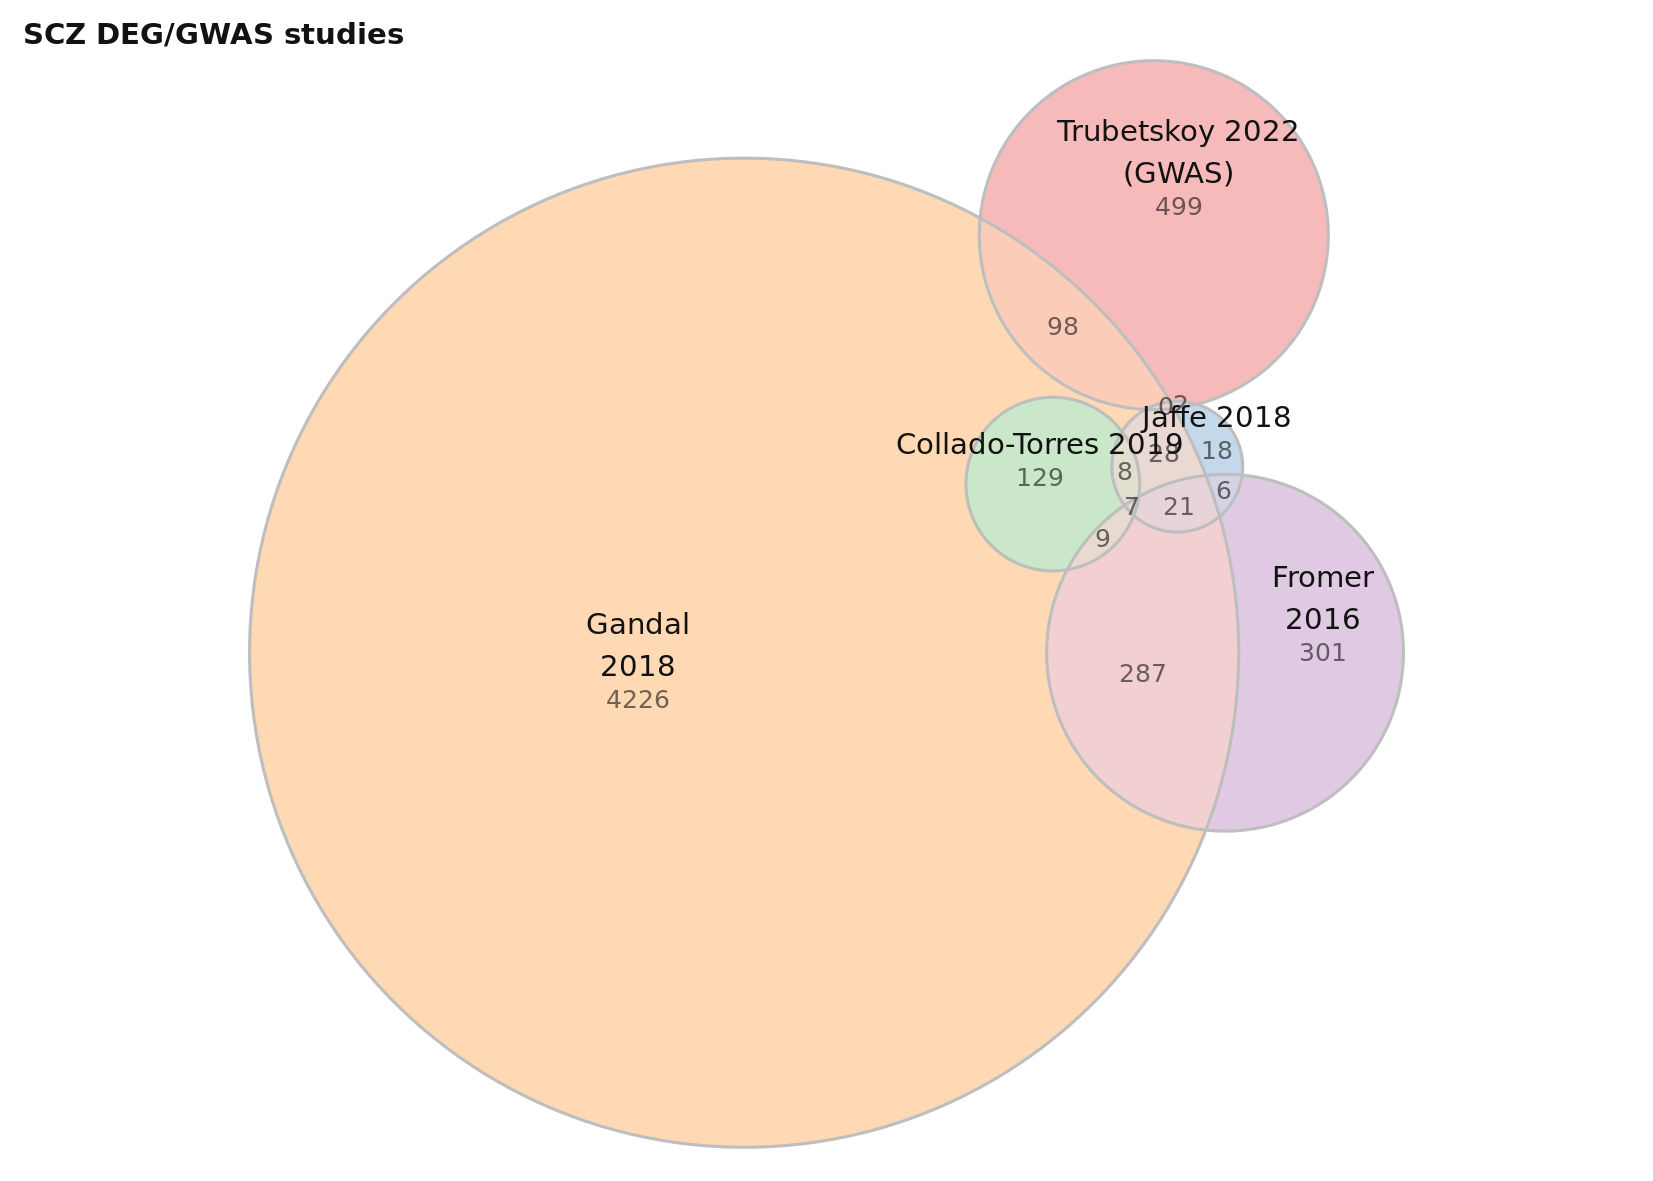

In [9]:
%%R -i overlaps -w 140 -h 100 -u mm -r 300
library(eulerr)
g_overlaps <- plot(euler(overlaps, shape = 'circle'),
     edges = list(col='grey'),
     fills = list(alpha = 0.3, fill = brewer.set1(5) %>% rev),
     labels = list(col = "grey7", fontsize = 7, cex=1, fontfamily='Calibri', font='plain'),
     quantities = list(col = "grey7", fontsize = 6, fontfamily='Calibri', alpha=.6),
     adjust_labels = T
) %>% wrap_elements + coord_cartesian(clip='off') + 
     ggtitle('SCZ DEG/GWAS studies') +
     theme(plot.title = element_text(size = 7, family='Calibri', color='grey7'))
g_overlaps

### Histograms by GWAS / DEG

In [10]:
get_deg_consensus()

,label,gene,study
1,ASD,AAGAB,2
4,ASD,AASDHPPT,2
5,ASD,AATK,2
7,ASD,ABCA1,3
8,ASD,ABCA10,3
...,...,...,...
10305,SCZ,ZNF808,2
10307,SCZ,ZNF815P,2
10309,SCZ,ZNF827,2
10310,SCZ,ZNF831,3


In [11]:
deg_scz = (get_deg_consensus()
           .loc[lambda x: x['label'] == 'SCZ']
           .rename({'label':'disorder'}, axis=1)
           .drop('study', axis=1)
)

deg_consensus_with_gwas = pd.concat([
    gwas_studies.loc[lambda x: x['disorder']=='SCZ'].assign(label='GWAS'),
    deg_scz.assign(label='DEGs (2+ studies only)')
])

quantiles = make_component_quantiles(weights, labels=None)

deg_consensus_with_gwas_quantiles = (
    deg_consensus_with_gwas
    .join(quantiles.set_index('gene').query("C == 'C3'"), on='gene')
    .dropna()
    .groupby(['C', 'C_quantile', 'label'], as_index=False)['C_score'].count()
    .rename({'C_score':'count'}, axis=1)
)
deg_consensus_with_gwas_quantiles.head()

,C,C_quantile,label,count
0,C3,1,DEGs (2+ studies only),19
1,C3,1,GWAS,11
2,C3,2,DEGs (2+ studies only),40
3,C3,2,GWAS,14
4,C3,3,DEGs (2+ studies only),25


/opt/conda/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "C_quantile". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  warnings.warn('Error while trying to convert '


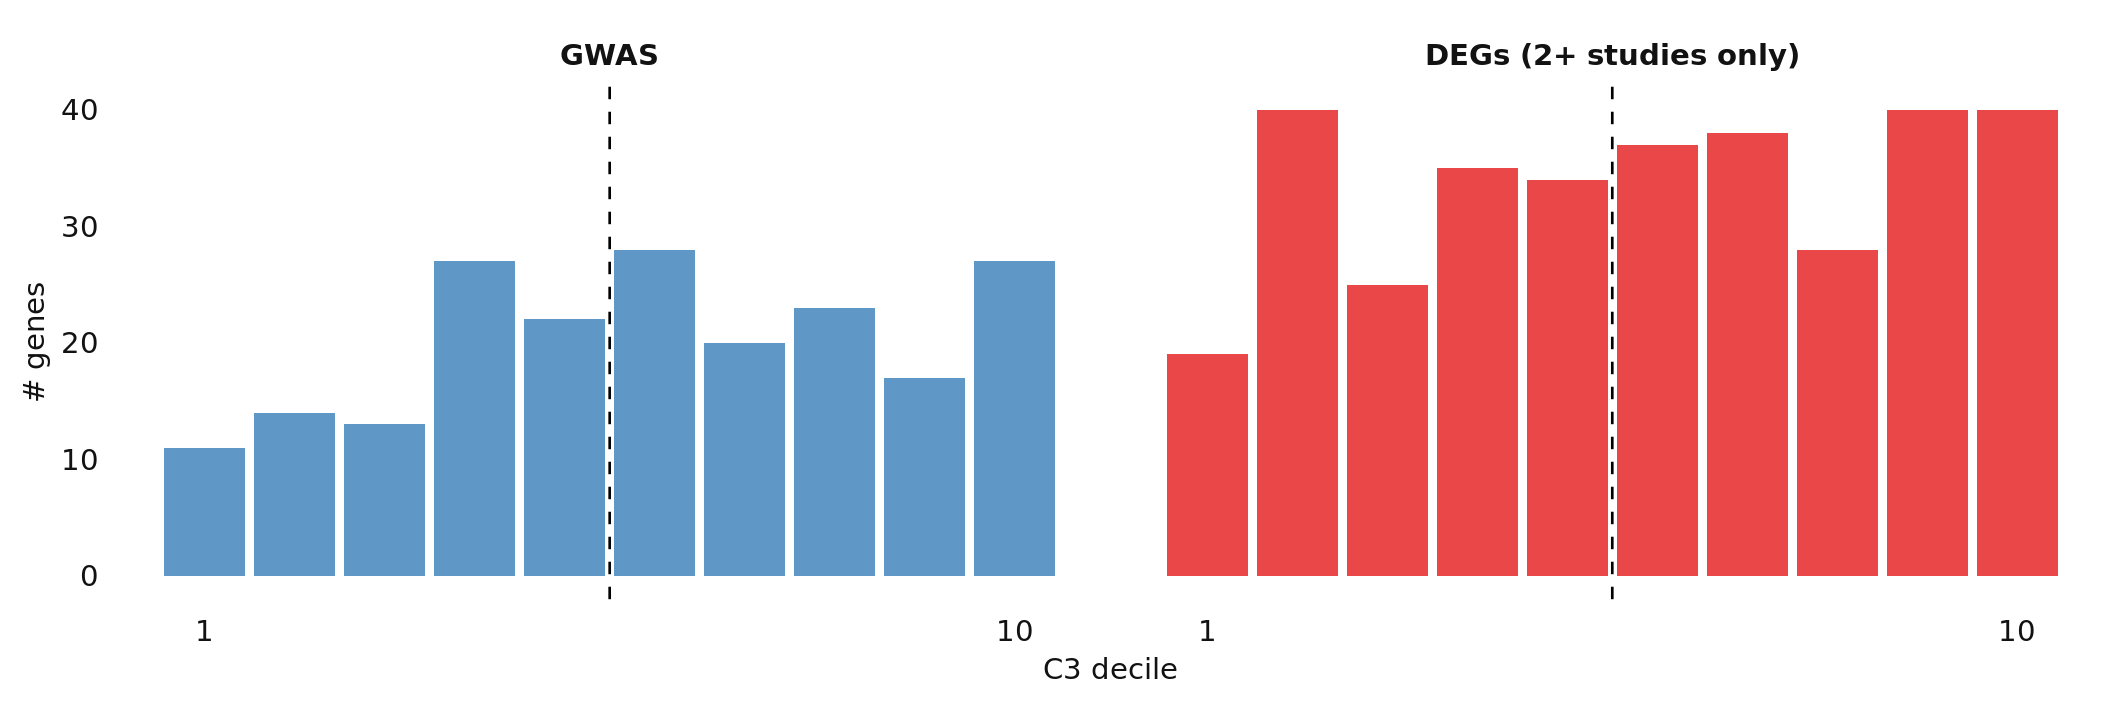

In [12]:
%%R -w 180 -h 60 -u mm -r 300 -i deg_consensus_with_gwas_quantiles
g_quantile_deg_gwas <- deg_consensus_with_gwas_quantiles %>% 
    mutate(label = factor(label, ordered=T, levels = unique(.$label) %>% rev)) %>% 
    ggplot(aes(x=as.integer(C_quantile), y=count, fill=label)) + 
    facet_wrap(~label, ncol=2) +
    geom_col(alpha=.8) + 
    geom_vline(xintercept=5.5, linetype=2, size=.3) +
    scale_fill_manual(values=brewer.set1(3)[c(2,1)]) +
    scale_x_continuous(breaks=c(1,10), 'C3 decile') +
    ylab('# genes') +
    guides(fill = 'none') + 
    theme(
        legend.position = 'right',
        strip.clip = 'off',
        strip.text = element_text(face='bold')
    )
g_quantile_deg_gwas

### Histograms by study

In [13]:
layer_levels = ['L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'WM', 'None']
quantiles = make_component_quantiles(weights, labels=get_layer_genes(), 
                                     levels=layer_levels, na_value='None')

scz_studies = (deg_studies_and_gwas
    .loc[lambda x: x['disorder']=='SCZ', 'label'].unique()
)

deg_quantile_layers = {}
for study in scz_studies:
    deg_quantile_layers[study] = (
        deg_studies_and_gwas
        .loc[lambda x: x['label'] == study, ['gene']]
        .set_index('gene')
        .join(quantiles.set_index('gene').query("C == 'C3'"))
        .dropna()
        .groupby(['C', 'C_quantile', 'label'], as_index=False)['C_score'].count()
        .rename({'C_score':'count'}, axis=1)
    )

deg_quantile_layers = pd.concat(deg_quantile_layers).reset_index(0).rename({'level_0':'study'}, axis=1)
deg_quantile_layers

,study,C,C_quantile,label,count
0,Gandal 2018,C3,1,L1,83
1,Gandal 2018,C3,1,L2,4
2,Gandal 2018,C3,1,L3,0
3,Gandal 2018,C3,1,L4,1
4,Gandal 2018,C3,1,L5,4
...,...,...,...,...,...
75,Trubetskoy 2022\n(GWAS),C3,10,L4,0
76,Trubetskoy 2022\n(GWAS),C3,10,L5,1
77,Trubetskoy 2022\n(GWAS),C3,10,L6,3
78,Trubetskoy 2022\n(GWAS),C3,10,WM,0


/opt/conda/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '
/opt/conda/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "C_quantile". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  warnings.warn('Error while trying to convert '


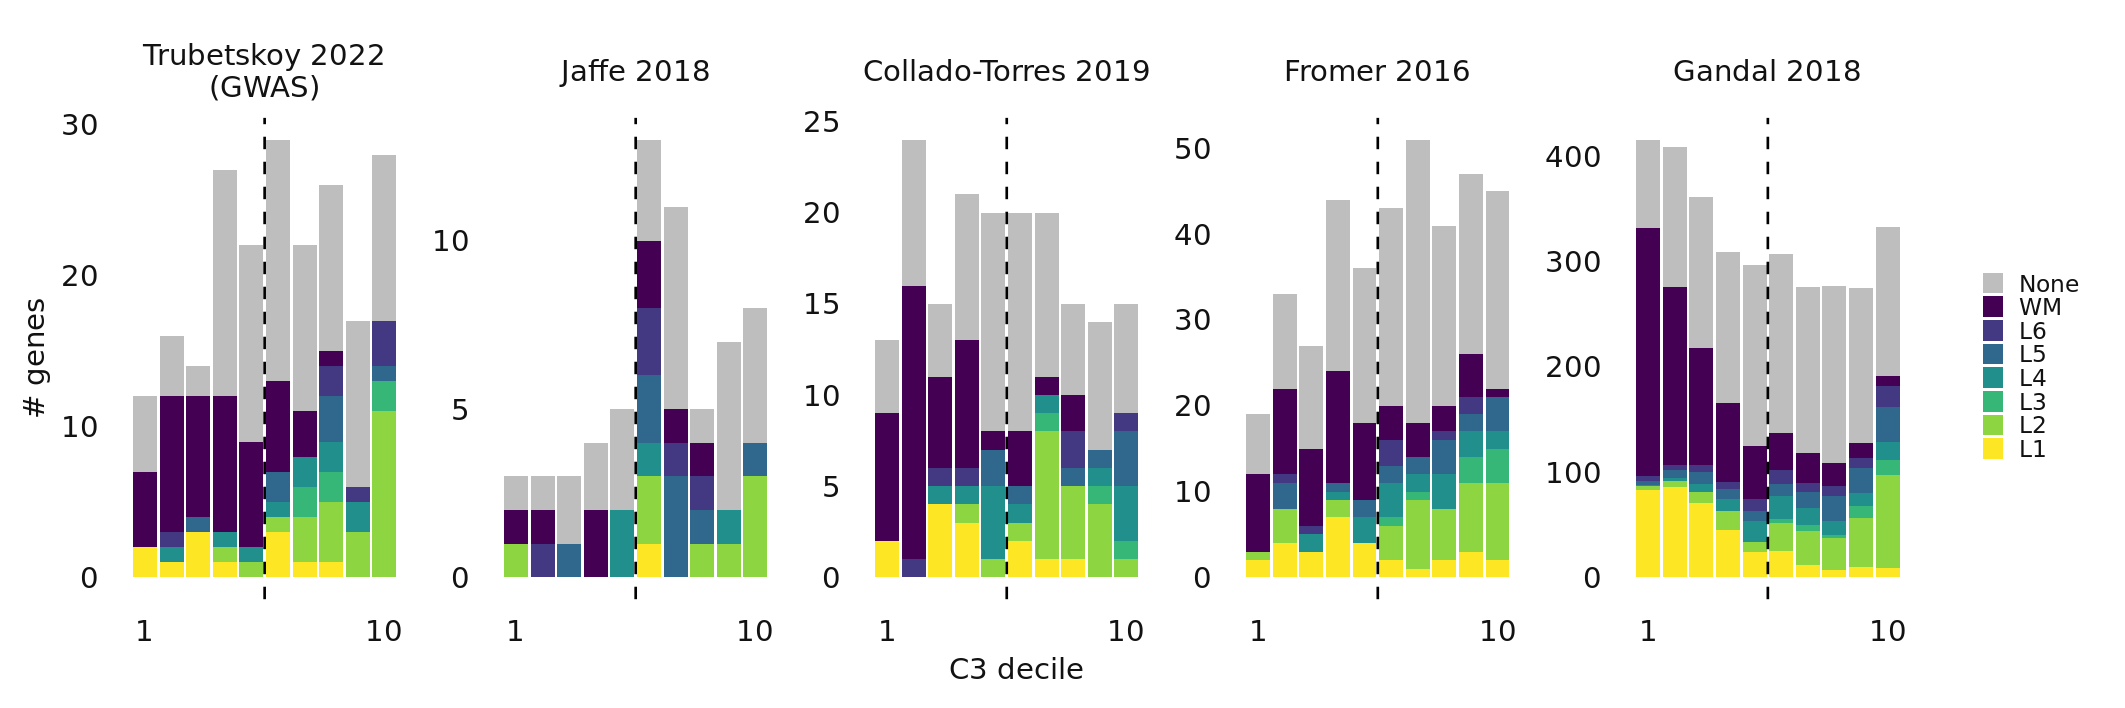

In [14]:
%%R -w 180 -h 60 -u mm -r 300 -i deg_quantile_layers
g_quantile_layers <- deg_quantile_layers %>% 
    mutate(label = factor(label, ordered=T, levels = unique(.$label) %>% rev)) %>% 
    mutate(study = factor(study, ordered=T, levels = unique(.$study) %>% rev)) %>% 
    ggplot(aes(x=as.integer(C_quantile), y=count, fill=label)) + 
    facet_wrap(~study, ncol=5, scales='free') +
    geom_col() + 
    geom_vline(xintercept=5.5, linetype=2, size=.3) +
    scale_fill_manual(values=c('grey', viridis(7))) +
    scale_x_continuous(breaks=c(1,10), 'C3 decile') +
    ylab('# genes') +
    guides(fill = guide_legend(title=NULL, override.aes = list(size=2))) + 
    theme(
        legend.position = 'right',
        strip.clip = 'off'
    )
g_quantile_layers

In [15]:
layer_enrichments_all = test_layers_all_combinations(
    background = weights.index, 
    disorder_genes = deg_studies_and_gwas, 
    layer_genes = get_layer_genes(add_hse_genes=False),
    reference_filter = None
)
# layer_enrichments_all

C3_positive = weights.loc[lambda x: x['C3']>0, :].index
C3_negative = weights.loc[lambda x: x['C3']<0, :].index

layer_enrichments_C3positive = test_layers_all_combinations(
    background = weights.index, 
    disorder_genes = deg_studies_and_gwas, 
    layer_genes = get_layer_genes(add_hse_genes=False),
    reference_filter = C3_positive
)
layer_enrichments_C3positive.head()

Done Gandal 2022-ASD.
Done Gandal 2018-ASD.
Done Parikshak 2016-ASD.
Done Matoba 2020
(GWAS)-ASD.
Done Jaffe 2022-MDD.
Done Howard 2019
(GWAS)-MDD.
Done Gandal 2018-SCZ.
Done Fromer 2016-SCZ.
Done Collado-Torres 2019-SCZ.
Done Jaffe 2018-SCZ.
Done Trubetskoy 2022
(GWAS)-SCZ.
Done Gandal 2022-ASD.
Done Gandal 2018-ASD.
Done Parikshak 2016-ASD.
Done Matoba 2020
(GWAS)-ASD.
Done Jaffe 2022-MDD.
Done Howard 2019
(GWAS)-MDD.
Done Gandal 2018-SCZ.
Done Fromer 2016-SCZ.
Done Collado-Torres 2019-SCZ.
Done Jaffe 2018-SCZ.
Done Trubetskoy 2022
(GWAS)-SCZ.


,label,disorder,layer,n,N,pct,odds_ratio,p,q,sig
0,Gandal 2022,ASD,L1,30,987,0.030395,0.325906,1.000000e+00,1.000000e+00,False
1,Gandal 2022,ASD,L2,82,987,0.083080,0.953923,6.679204e-01,9.956814e-01,False
2,Gandal 2022,ASD,L3,8,987,0.008105,0.733216,8.420976e-01,1.000000e+00,False
3,Gandal 2022,ASD,L4,81,987,0.082067,4.309020,8.771184e-21,3.376906e-19,True
4,Gandal 2022,ASD,L5,94,987,0.095238,3.283531,1.173437e-17,3.011821e-16,True


Scale for size is already present.
Adding another scale for size, which will replace the existing scale.
Scale for size is already present.
Adding another scale for size, which will replace the existing scale.
Scale for size is already present.
Adding another scale for size, which will replace the existing scale.
Scale for size is already present.
Adding another scale for size, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


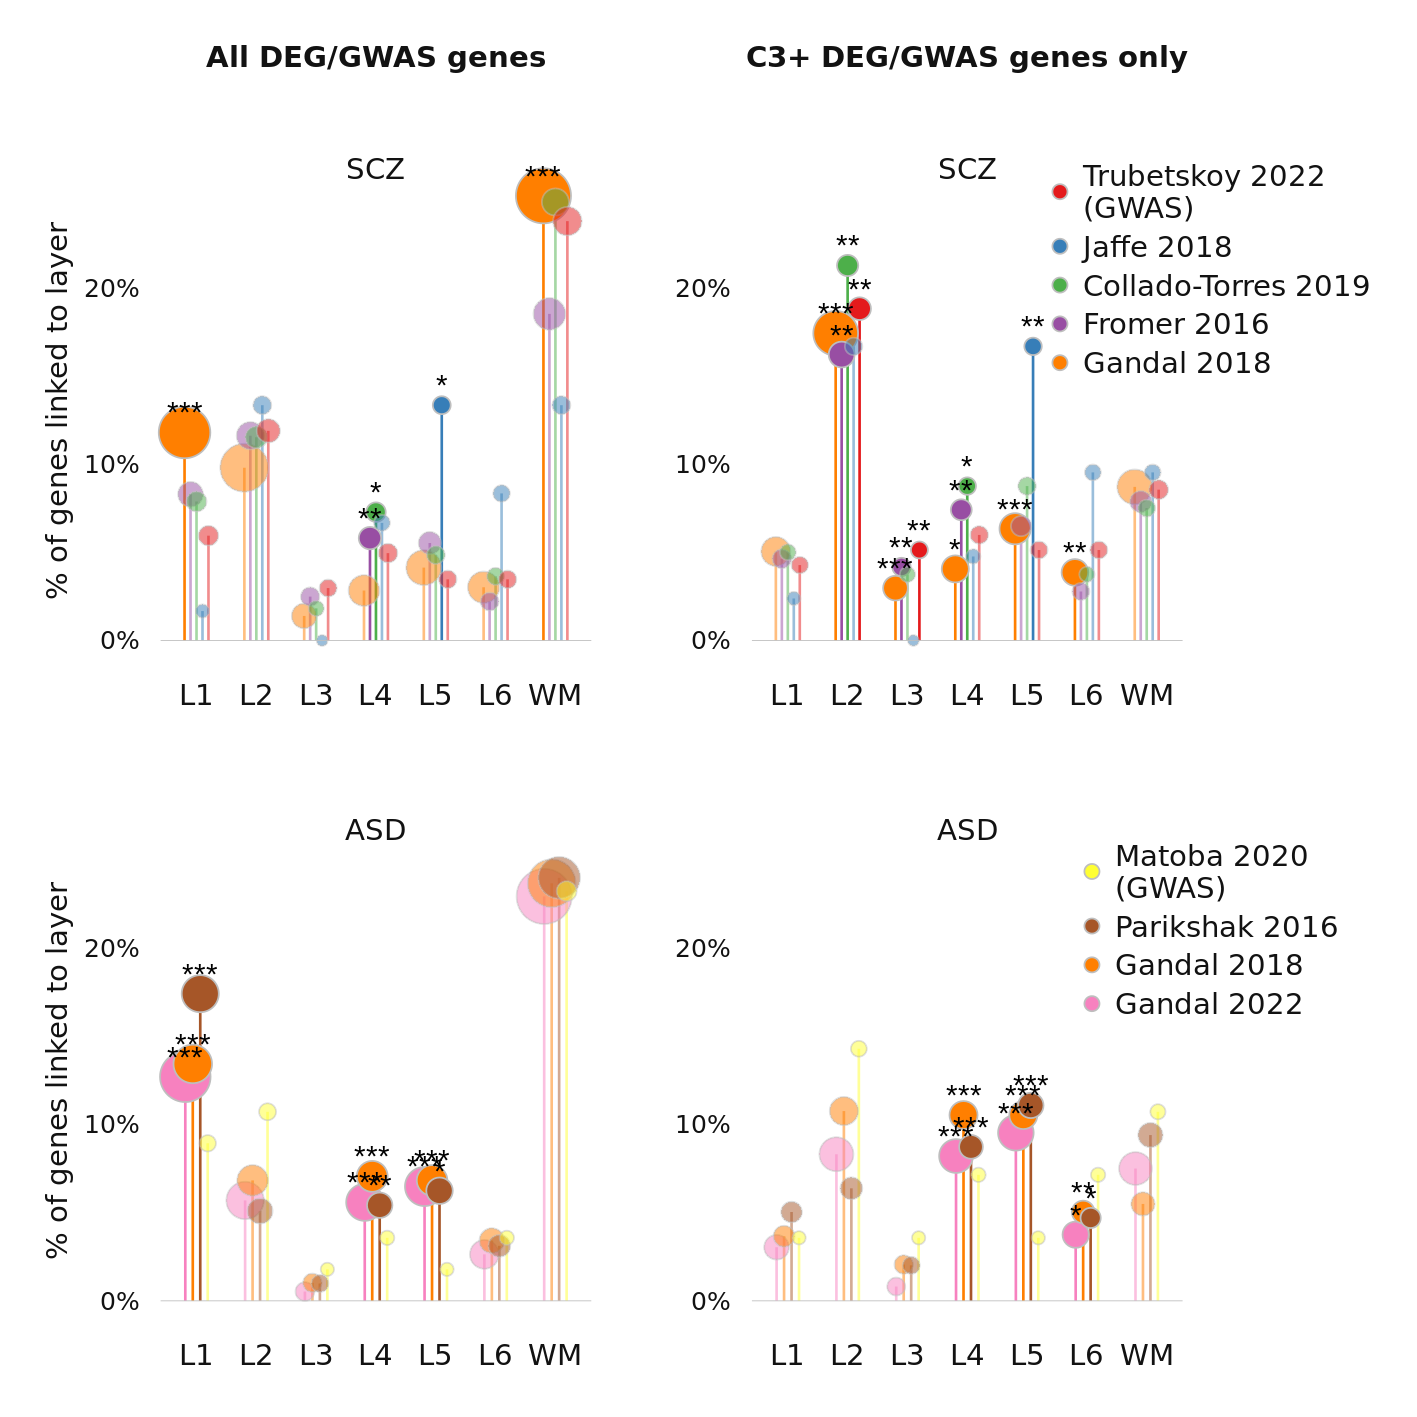

In [16]:
%%R -w 120 -h 120 -u mm -r 300 -i layer_enrichments_C3positive -i layer_enrichments_all
source("../code/fig4_plots.R")

colors_scz <- brewer.set1(5)
colors_asd <- brewer.set1(8)[c(6,7,5,8)]

layer_enrichments_all <- layer_enrichments_all %>% 
            mutate(label = factor(label, ordered=T, levels=unique(.$label) %>% rev)) %>% arrange(label) %>% 
            mutate(n = pmin(n, 300))

layer_enrichments_C3positive <- layer_enrichments_C3positive %>% 
            mutate(label = factor(label, ordered=T, levels=unique(.$label) %>% rev)) %>% arrange(label) %>% 
            mutate(n = pmin(n, 300))

g_layers_all_scz <- layer_enrichments_all %>% 
            filter(disorder == 'SCZ') %>% 
            plot_disorder_layer_enrichments(ylab='% of genes linked to layer', colors=colors_scz) + 
            ggtitle('All DEG/GWAS genes')

g_layers_c3_scz <- layer_enrichments_C3positive %>% 
            filter(disorder == 'SCZ') %>% 
            plot_disorder_layer_enrichments(ylab='', colors=colors_scz) + 
            ggtitle('C3+ DEG/GWAS genes only')

g_layers_all_asd <- layer_enrichments_all %>% 
            filter(disorder == 'ASD') %>% 
            plot_disorder_layer_enrichments(ylab='% of genes linked to layer', colors=colors_asd)

g_layers_c3_asd <- layer_enrichments_C3positive %>% 
            filter(disorder == 'ASD') %>% 
            plot_disorder_layer_enrichments(ylab='', colors=colors_asd)


g_layers_scz <- g_layers_all_scz + g_layers_c3_scz + plot_layout(guides='collect')
g_layers_asd <- g_layers_all_asd + g_layers_c3_asd + plot_layout(guides='collect', tag_level='new')

g_layer_enrichments <- (
    (g_layers_scz / g_layers_asd) & 
    guides(size = 'none', fill = guide_legend(byrow=T)) &
    scale_size_continuous(limits=c(0,300)) & 
    scale_y_continuous(limits=c(0,0.26), labels=percent) &
    xlab(NULL)
) & 
theme(
    legend.position = 'right', 
    legend.margin = margin(0,0,25,-15,'mm'),
    legend.spacing.y = unit(1,'mm'),
    plot.tag.position = c(0,1)
    # legend.text = element_text(size=6),
    # strip.text = element_blank()
)

g_layer_enrichments

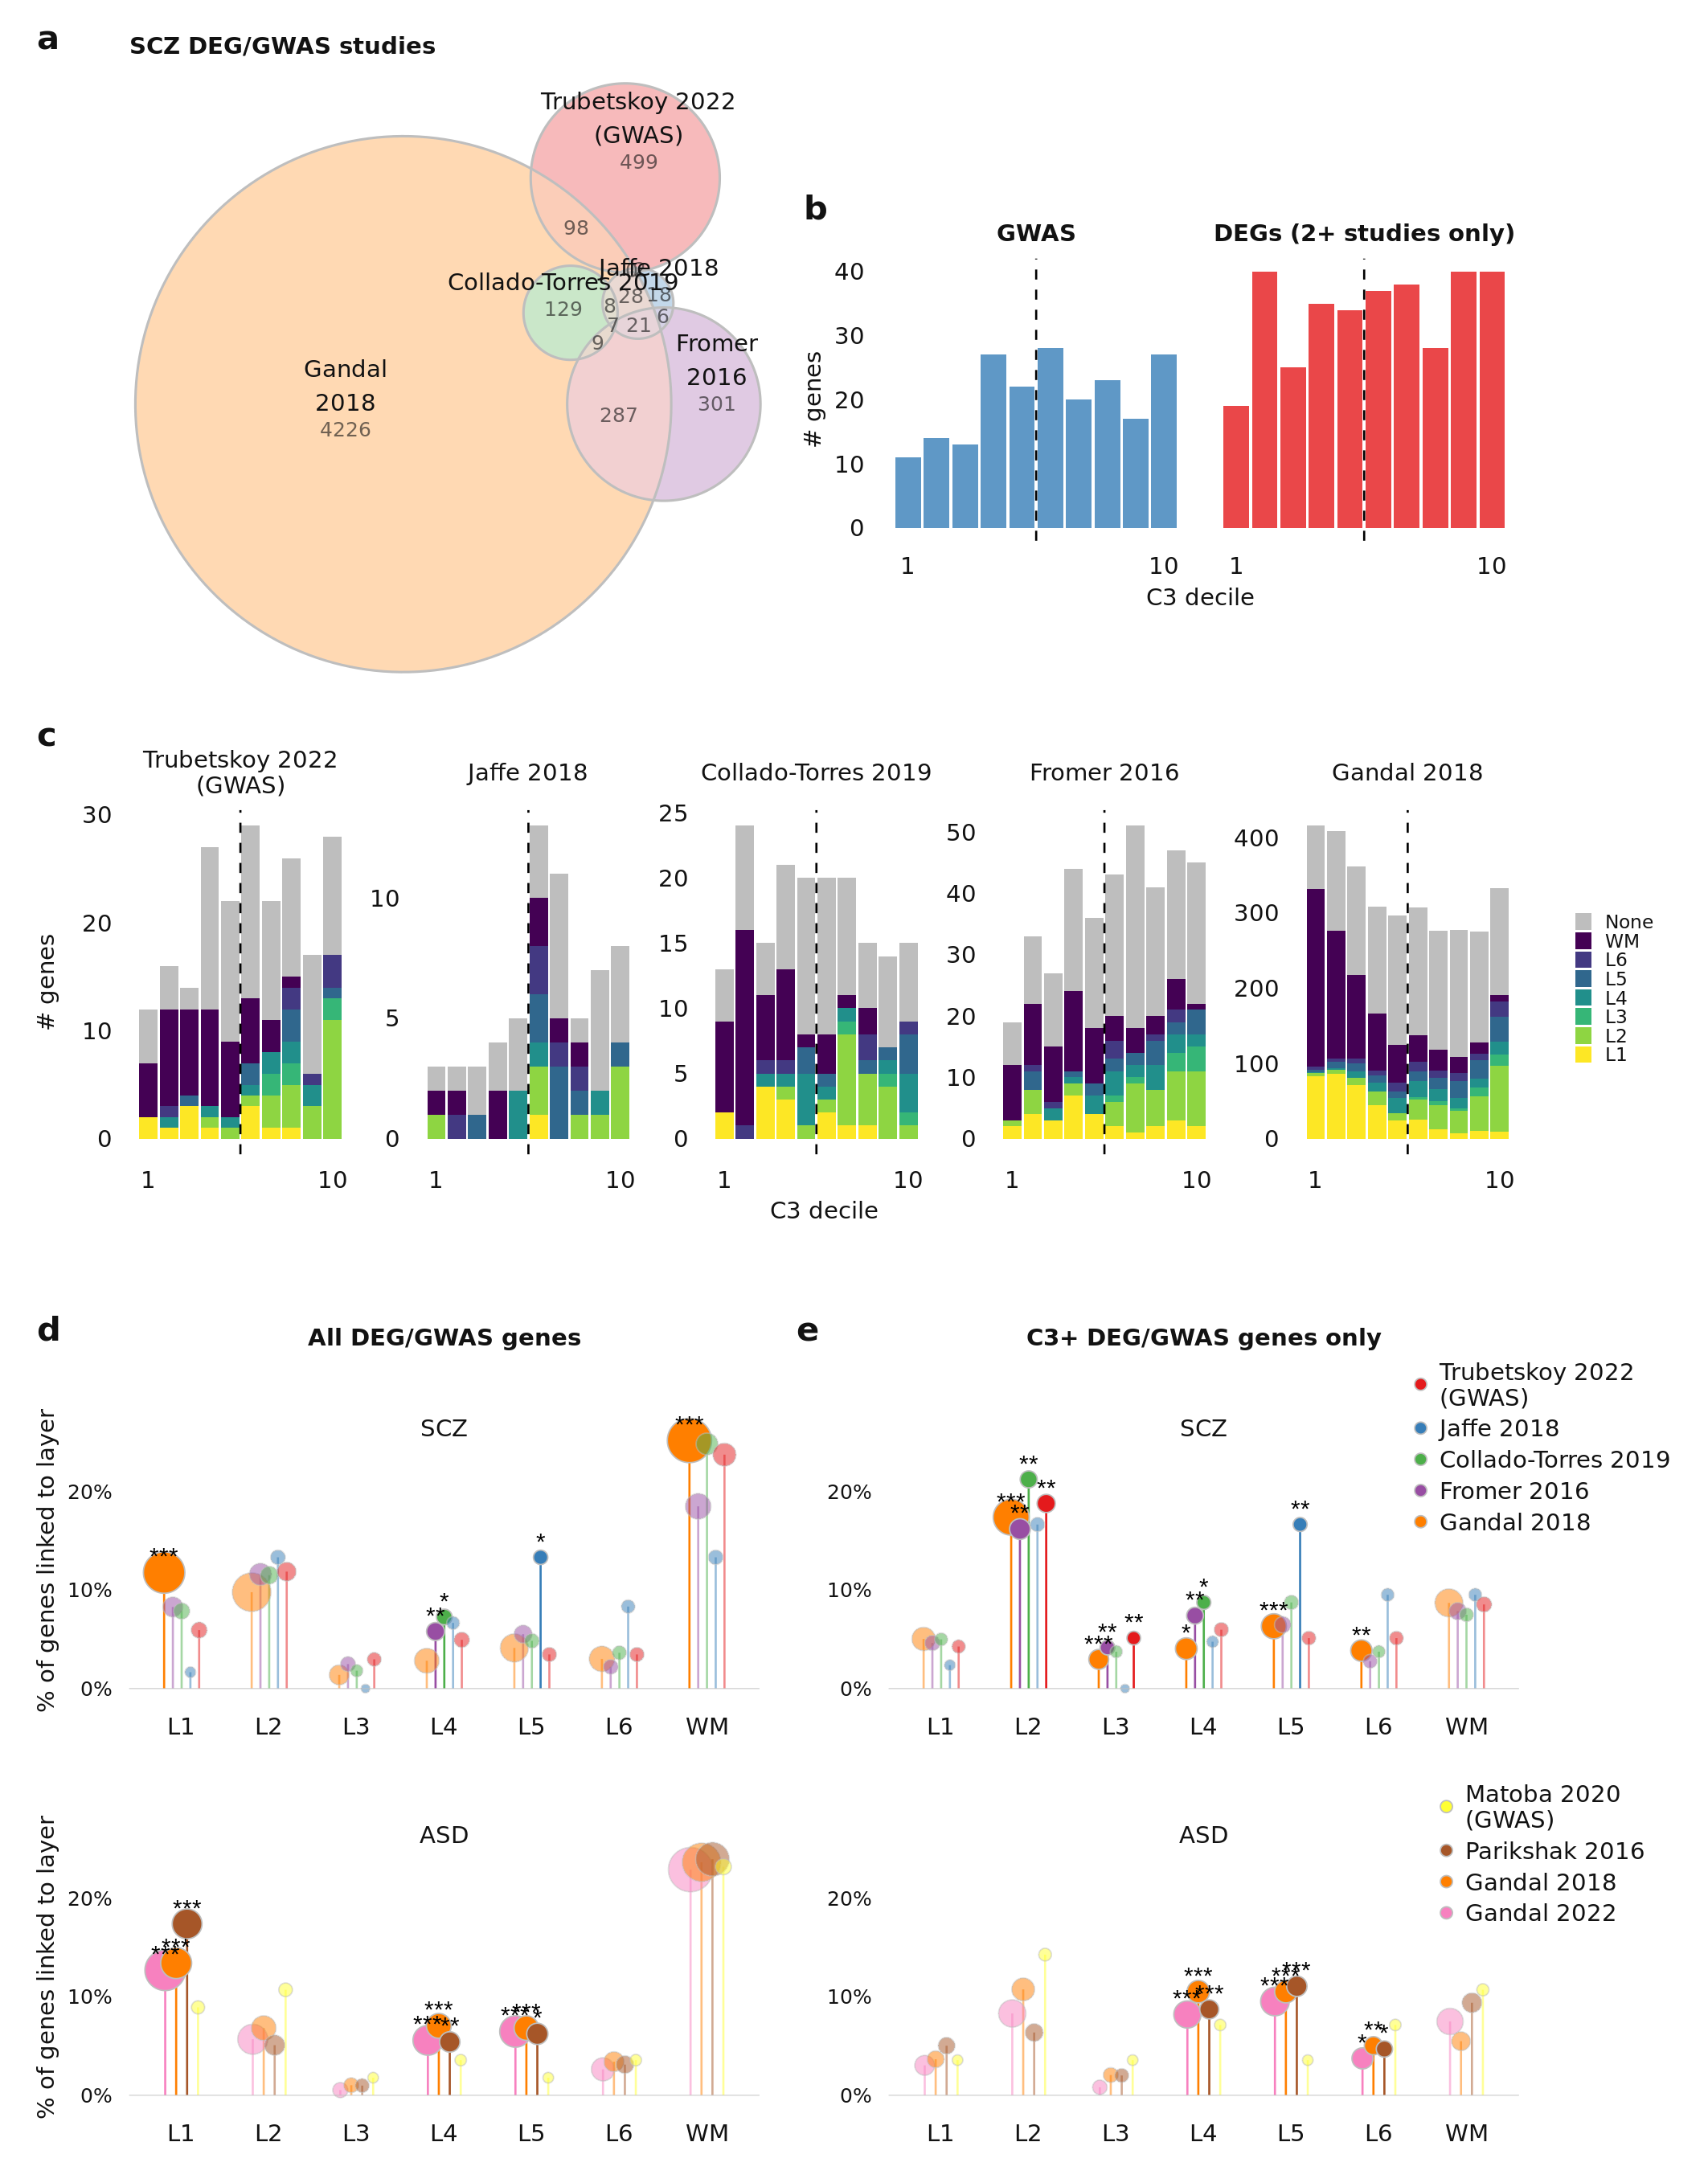

In [20]:
%%R -w 180 -h 230 -u mm -r 300

layout <- c(
    area(t=1,b=70,l=1,r=90),
    area(t=20,b=60,l=91,r=180),
    area(t=71,b=120,l=1,r=180),
    area(t=131,b=230,l=1,r=180)
)

plot <- g_overlaps + g_quantile_deg_gwas + g_quantile_layers + g_layer_enrichments + plot_layout(design=layout) 
annotated <- plot + plot_annotation(tag_level='a')
annotated

In [21]:
%%R
ggsave(file="../outputs/figures/fig_ext_6.svg", plot=annotated, width=180, height=230, units='mm')